In [21]:
import rasterio
from rasterio.windows import get_data_window,Window, from_bounds
import matplotlib.pyplot as plt
from rasterio.plot import show
from rasterio.enums import Resampling
import pandas as pd
import numpy as np
from shapely.geometry import Point
import geopandas as gpd
import datetime
from joblib import Parallel, delayed
import pyproj
import cartopy.crs as ccrs
import xarray as xr
import rioxarray as rioxr

In [2]:
fire_incidents = ['BOBCAT']

path_poly = '/data2/lthapa/ML_daily/fire_polygons/'
suffix_poly = 'Z_day_start.geojson'
start_time=12
for jj in range(len(fire_incidents)):
    fire_name = fire_incidents[jj].lower().replace(' ','_')
    print(path_poly+fire_name+'_VIIRS_daily_'+str(start_time)+suffix_poly)
    fire_daily = gpd.read_file(path_poly+fire_name+'_VIIRS_daily_'+str(start_time)+suffix_poly)
    print(fire_daily.crs)
    fire_daily=fire_daily.drop(columns=['Current Overpass'])
    fire_daily = fire_daily.drop(np.where(fire_daily['geometry']==None)[0])
    fire_daily['fire area (ha)'] = fire_daily['geometry'].area/10000 #hectares. from m2
    fire_daily.set_geometry(col='geometry', inplace=True) #designate the geometry column
    fire_daily = fire_daily.rename(columns={'Current Day':'UTC Day', 'Local Day': str(start_time)+ 'Z Start Day'})
    
    fire_daily = fire_daily.iloc[np.array(fire_daily['UTC Day'].values,dtype='datetime64')<=np.datetime64('2020-10-31'),:]

/data2/lthapa/ML_daily/fire_polygons/bobcat_VIIRS_daily_12Z_day_start.geojson
epsg:3347


In [6]:
bobcat_fwi = xr.open_dataset('./bobcat_fuel_fwi.nc')
print(bobcat_fwi)

<xarray.Dataset>
Dimensions:     (col: 484, row: 461)
Coordinates:
  * row         (row) int64 0 1 2 3 4 5 6 7 ... 453 454 455 456 457 458 459 460
  * col         (col) int64 0 1 2 3 4 5 6 7 ... 476 477 478 479 480 481 482 483
    lat_ctr     (row, col) float64 ...
    lon_ctr     (row, col) float64 ...
Data variables:
    Extreme_N   (row, col) float64 ...
    Extreme_R   (row, col) float64 ...
    VeryHigh_N  (row, col) float64 ...
    VeryHigh_R  (row, col) float64 ...
    High_N      (row, col) float64 ...
    High_R      (row, col) float64 ...
    Moderate_N  (row, col) float64 ...
    Moderate_R  (row, col) float64 ...
    Low_N       (row, col) float64 ...
    Low_R       (row, col) float64 ...
    y_ctr       (row, col) float64 ...
    x_ctr       (row, col) float64 ...


In [13]:
poly = fire_daily[10:11].to_crs('epsg:4326')
print(poly)

   12Z Start Day  Incident Number Fire Name     UTC Day   Lat Fire  \
10    2020-09-15       11951011.0    BOBCAT  2020-09-16  34.248056   

      Lon Fire  Number of NEW VIIRS points  NEW FRP  \
10 -117.959167                       134.0   6711.3   

                                             geometry  fire area (ha)  
10  MULTIPOLYGON (((-118.05186 34.22079, -118.0518...     2190.483966  


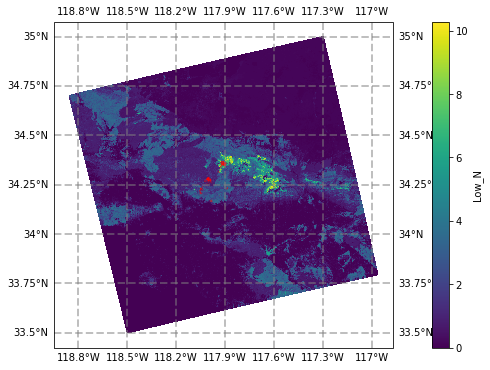

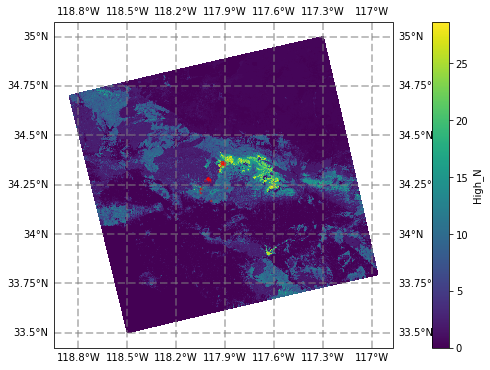

In [20]:
plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
bobcat_fwi['Low_N'].plot(ax=ax,transform=ccrs.PlateCarree(), x="lon_ctr", y="lat_ctr")
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
poly.plot(ax=ax,color='r')
plt.show()

plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
bobcat_fwi['High_N'].plot(ax=ax,transform=ccrs.PlateCarree(), x="lon_ctr", y="lat_ctr")
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
poly.plot(ax=ax,color='r')
plt.show()

In [47]:
xds = rioxr.open_rasterio('./bobcat_fuel_fwi.nc')
xds.rio.write_crs('epsg:4326', inplace = True)

clipped = xds.rio.clip(poly.geometry.values, poly.crs)


NoDataInBounds: No data found in bounds. Data variable: Extreme_N